In [1]:
# The jupyter script is used to carry out the analysis of the single run
# this is an ETL process: extract (from database), transform (preprocessing techniques), load (numPy arrays)
# from the music therapy study using a 12 seconds sliding window
# dataset is resampled due to undersampling during the recording
# ICA, notch and bandpass filtering are implmeneted to mitigate eeg noise
# results: spectogram and average bandpower comparison betwen timepoints per channel per brainwave

In [2]:
from helper import*
import params as cfg

In [3]:
def zipExtract(filenames,localDirectory,destDirectory,variableName,sFreq,data_collection_time,sampling_state):
    #print("\n")
    #print("zip files in "+ variableName+":")
    def zipExt(filename,localDirectory,destDirectory,variableName):
        zf = ZipFile(localDirectory+filename, 'r')
        path = destDirectory+variableName
        zf.extractall(path)
        zf.close()
    zipOutputs = []
    for filename in filenames:
        zipOutputs.append(zipExt(filename,localDirectory,destDirectory,variableName))
        #print(filename)
    files_dest = next(walk(destDirectory+variableName), (None, None, []))[2]
    files_dest = [f for f in files_dest if f.endswith('.csv')]
    resampled_data = []
    resampled_time = []
    for I in range(len(files_dest)):
        resampled_data.append(singleTransformToRawEEG((pd.read_csv(destDirectory+variableName+'/'+files_dest[I]))[['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']],sFreq,data_collection_time,sampling_state)[0])
        resampled_time.append(singleTransformToRawEEG((pd.read_csv(destDirectory+variableName+'/'+files_dest[I]))[['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']],sFreq,data_collection_time,sampling_state)[1])
    resampled_data = np.array(resampled_data)
    resampled_time = np.array(resampled_time)
    #print("\n")
    #print(variableName + " zip files contents:")
    #print(files_dest)
    return files_dest,resampled_data,resampled_time

def avgBandPower(data,fs,low,high):
    #  Inputs  :   data    - 2D numpy array (d0 = samples, d1 = channels) of filtered EEG data
    #              or data - 3D numpy array (d0 = channels, d1 = no of windows, d2 = length of windows) of unfiltered EEG data
    #              fs      - sampling rate of hardware (defaults to config)
    #              low     - lower limit in Hz for the brain wave
    #              high    - upper limit in Hz for the brain wave
    #              win     - size of window to be used for sliding
    #   Output  :   3D array (columns of array,no of windows,window size)
    def absPower(data,fs,low,high): 
        win = 4*fs                                                
        freqs, psd = signal.welch(data,fs,nperseg=win)
        idx_freqBands = np.logical_and(freqs >= low, freqs <= high) 
        freq_res = freqs[1] - freqs[0]                                  
        freqBand_power = simps(psd[idx_freqBands],dx=freq_res)  
        return freqBand_power
    avg_BandPower = []
    for i in range(len(data.T)):
        avg_BandPower.append(absPower(data[:,i],fs,low,high))
    avg_BandPower= np.array(avg_BandPower).T
    return avg_BandPower

In [4]:
# group-task-time
M = [['m11_1.zip'],['m12_1.zip']]
localDir = "/Users/joshuaighalo/Downloads/Mind_Monitor-2/"
destDir = "/Users/joshuaighalo/Downloads/Mind_Monitor-2/dest/"
os.system('rm -rf %s/*' % destDir)
fs_setting = 'constant'

/var/folders/ry/jhpq361x33g2tv7b7l6j0md80000gn/T/ipykernel_85313/198614571.py:1: DtypeWarning: Columns (38) have mixed types.Specify dtype option on import or set low_memory=False.
  MT11 = zipExtract(M[0],localDir,destDir,"M11",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
/var/folders/ry/jhpq361x33g2tv7b7l6j0md80000gn/T/ipykernel_85313/198614571.py:5: DtypeWarning: Columns (38) have mixed types.Specify dtype option on import or set low_memory=False.
  time_s = zipExtract(M[0],localDir,destDir,"M11",cfg.fs,cfg.collection_time,cfg.fs_setting)[2][0]


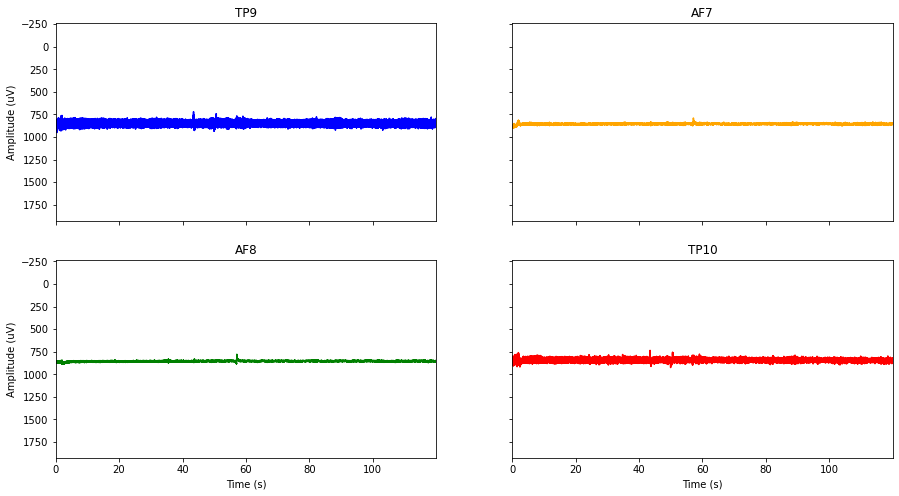

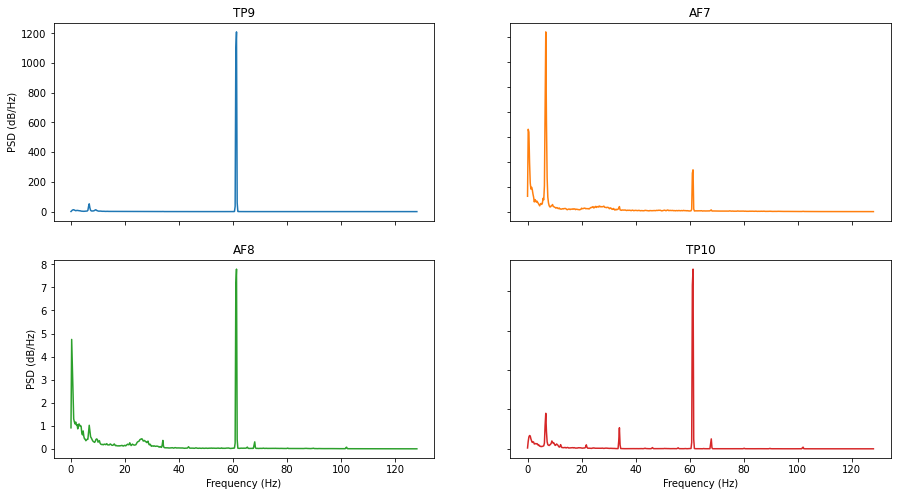

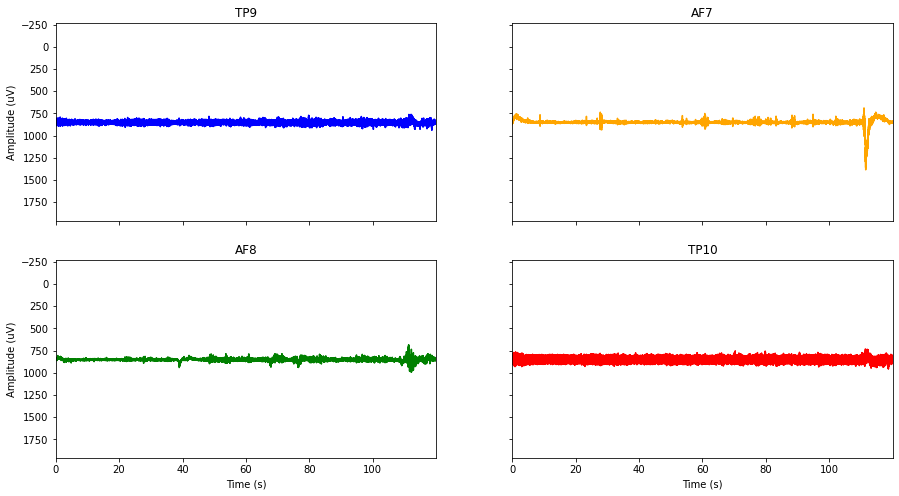

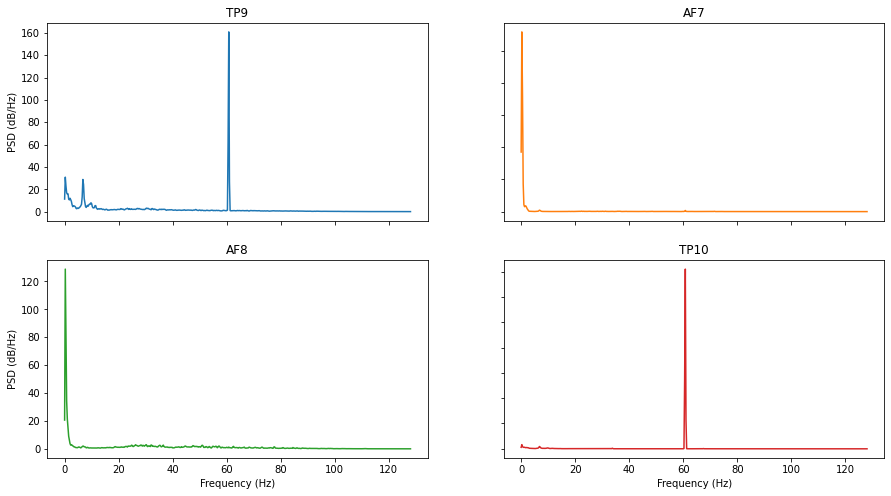

In [5]:
MT11 = zipExtract(M[0],localDir,destDir,"M11",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
MT11 = MT11.reshape(MT11.shape[1],MT11.shape[2])
MT12 = zipExtract(M[1],localDir,destDir,"M12",cfg.fs,cfg.collection_time,cfg.fs_setting)[1]
MT12 = MT12.reshape(MT12.shape[1],MT12.shape[2])
time_s = zipExtract(M[0],localDir,destDir,"M11",cfg.fs,cfg.collection_time,cfg.fs_setting)[2][0]
time_s = time_s.reshape(len(time_s),1)
time_s = time_s[0:int(cfg.collection_time*cfg.fs)]

plots(time_s,MT11,cfg.channels,['blue','orange','green','red'])
psdPlots(MT11,cfg.fs,cfg.channels)
plots(time_s,MT12,cfg.channels,['blue','orange','green','red'])
psdPlots(MT12,cfg.fs,cfg.channels)

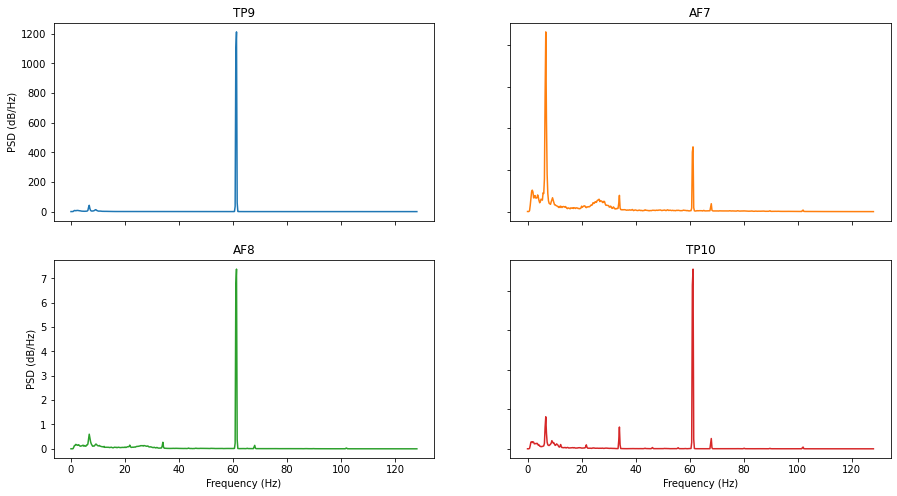

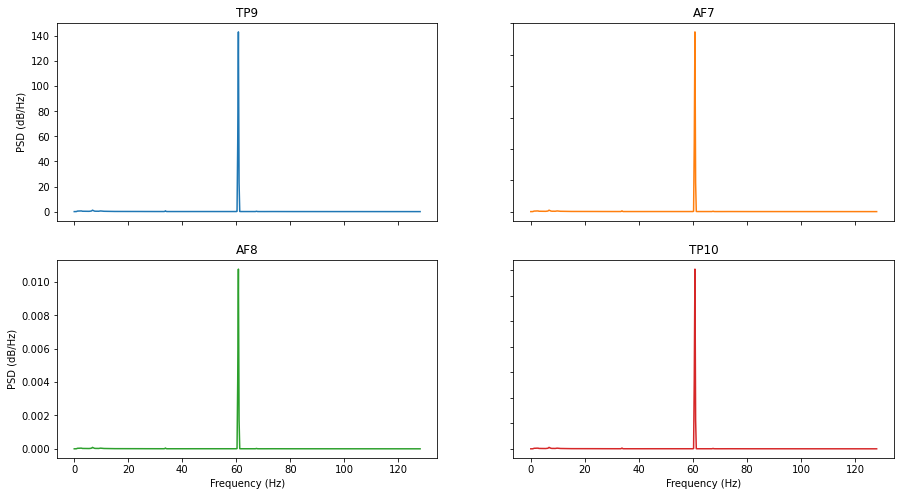

In [6]:
ica_MT11 = ica(MT11,cfg.fs)
ica_MT12 = ica(MT12,cfg.fs)
psdPlots(ica_MT11,cfg.fs,cfg.channels)
psdPlots(ica_MT12,cfg.fs,cfg.channels)

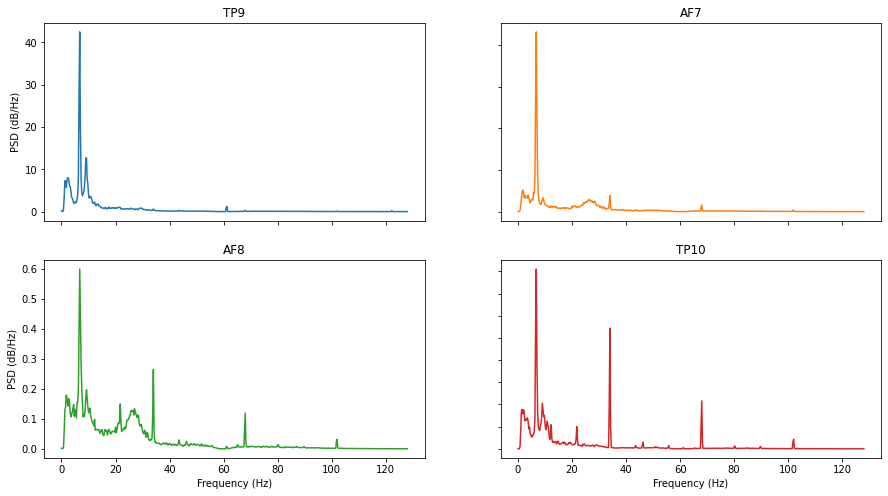

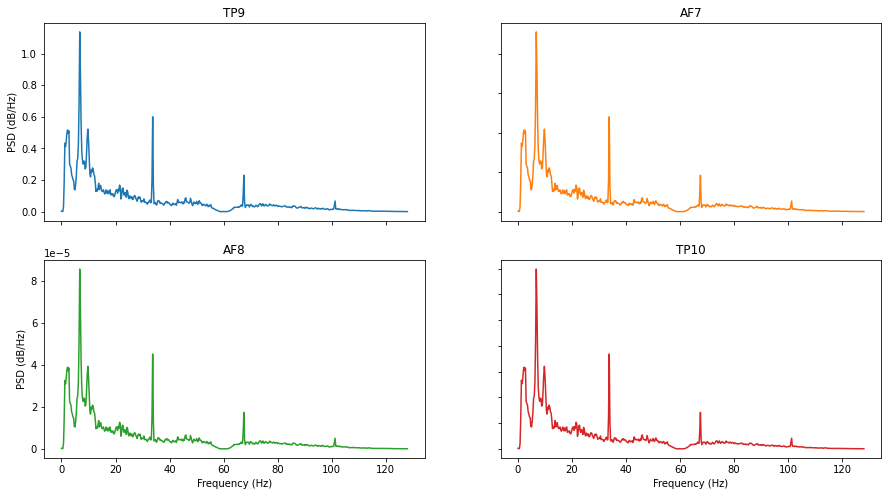

In [7]:
filtering = filters()
noc_MT11 = filtering.notch(ica_MT11,cfg.line,cfg.fs,5)
noc_MT12 = filtering.notch(ica_MT12,cfg.line,cfg.fs,5)
psdPlots(noc_MT11,cfg.fs,cfg.channels)
psdPlots(noc_MT12,cfg.fs,cfg.channels)


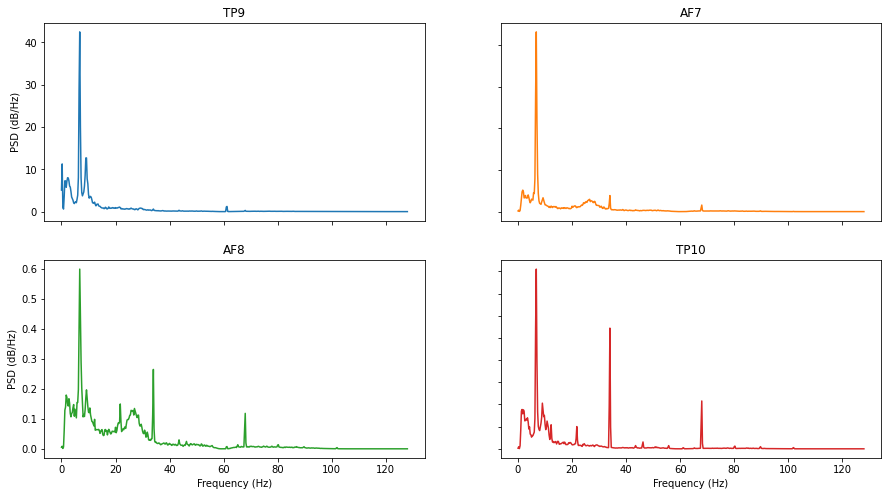

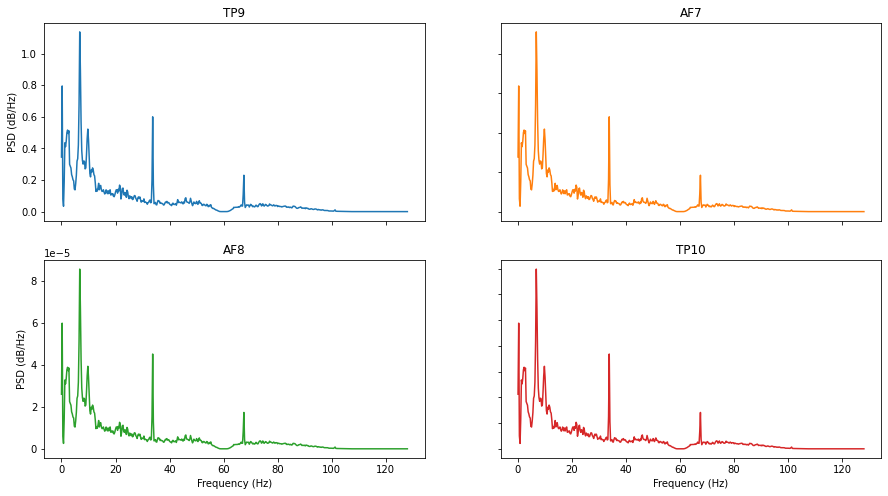

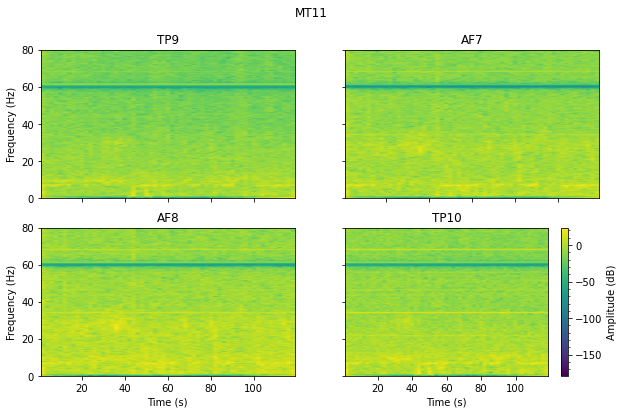

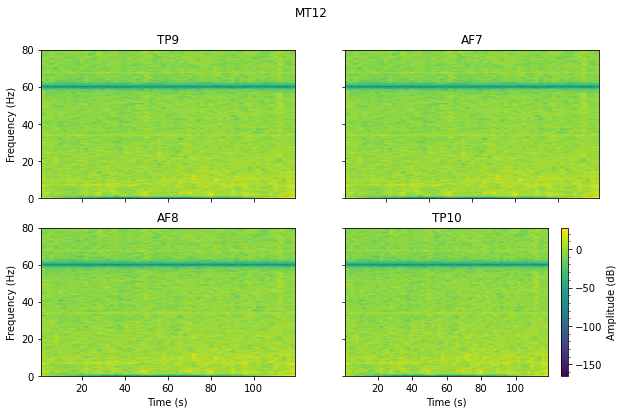

In [8]:
bandpass_MT11 = filtering.butterBandPass(noc_MT11,cfg.lowcut,cfg.highcut,cfg.fs,)
bandpass_MT12 = filtering.butterBandPass(noc_MT12,cfg.lowcut,cfg.highcut,cfg.fs,)
psdPlots(bandpass_MT11,cfg.fs,cfg.channels)
psdPlots(bandpass_MT12,cfg.fs,cfg.channels)
spectogramPlot(bandpass_MT11,cfg.fs,1024,512,(10,6),cfg.channels,'MT11')
spectogramPlot(bandpass_MT12,cfg.fs,1024,512,(10,6),cfg.channels,'MT12')

In [9]:
# compute power spectrum of each window per channel
delta_low = cfg.brainwaves['delta'][0]
delta_high = cfg.brainwaves['delta'][1]
theta_low = cfg.brainwaves['theta'][0]
theta_high = cfg.brainwaves['theta'][1]
alpha_low = cfg.brainwaves['alpha'][0]
alpha_high = cfg.brainwaves['alpha'][1]
beta_low = cfg.brainwaves['beta'][0]
beta_high = cfg.brainwaves['beta'][1]
gamma_low = cfg.brainwaves['gamma'][0]
gamma_high = cfg.brainwaves['gamma'][1]

In [10]:
# compute average band power for timepoint 1

#   delta
delta_M11 = avgBandPower(bandpass_MT11,cfg.fs,delta_low,delta_high)
delta_M12 = avgBandPower(bandpass_MT12,cfg.fs,delta_low,delta_high) 

#   theta
theta_M11 = avgBandPower(bandpass_MT11,cfg.fs,theta_low,theta_high)
theta_M12 = avgBandPower(bandpass_MT12,cfg.fs,theta_low,theta_high)

#   alpha
alpha_M11 = avgBandPower(bandpass_MT11,cfg.fs,alpha_low,alpha_high)
alpha_M12 = avgBandPower(bandpass_MT12,cfg.fs,alpha_low,alpha_high)

#   beta
beta_M11 = avgBandPower(bandpass_MT11,cfg.fs,beta_low,beta_high)
beta_M12 = avgBandPower(bandpass_MT12,cfg.fs,beta_low,beta_high)

#   gamma
gamma_M11 = avgBandPower(bandpass_MT11,cfg.fs,gamma_low,gamma_high)
gamma_M12 = avgBandPower(bandpass_MT12,cfg.fs,gamma_low,gamma_high)

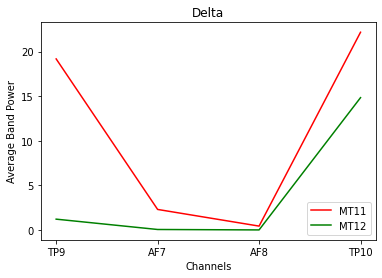

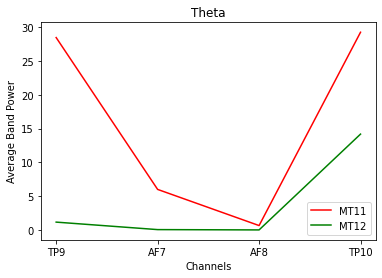

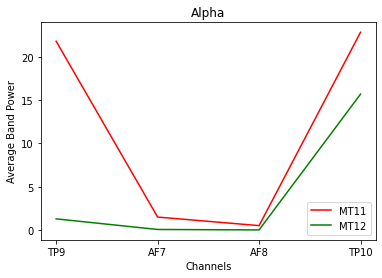

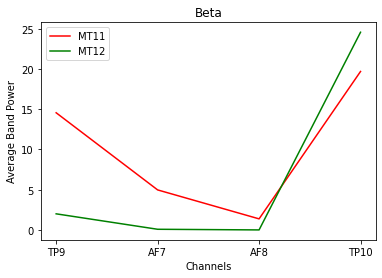

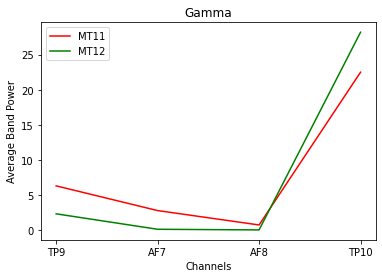

In [11]:
bandPowerPlots(cfg.channels,[delta_M11,delta_M12],['MT11','MT12'],['red','green'],'Delta')
bandPowerPlots(cfg.channels,[theta_M11,theta_M12],['MT11','MT12'],['red','green'],'Theta')
bandPowerPlots(cfg.channels,[alpha_M11,alpha_M12],['MT11','MT12'],['red','green'],'Alpha')
bandPowerPlots(cfg.channels,[beta_M11,beta_M12],['MT11','MT12'],['red','green'],'Beta')
bandPowerPlots(cfg.channels,[gamma_M11,gamma_M12],['MT11','MT12'],['red','green'],'Gamma')